<a href="https://colab.research.google.com/github/Anushka-Punukollu/Image-Colourization-with-GANs/blob/main/Image_Colourization_with_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Image Colourization with GANs + U-Net**

In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
Path.ls = lambda x: list(x.iterdir())

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import multiprocessing
import matplotlib.pyplot as plt

In [2]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [3]:
if use_colab == True:
   path = coco_path
else:
   path = "Your path to the dataset"
    
paths = glob.glob(path + "/*.jpg")  
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False)  
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000]  
val_idxs = rand_idxs[8000:] 
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print("Train size: ", len(train_paths))
print("Val size: ", len(val_paths))


Train size:  8000
Val size:  2000


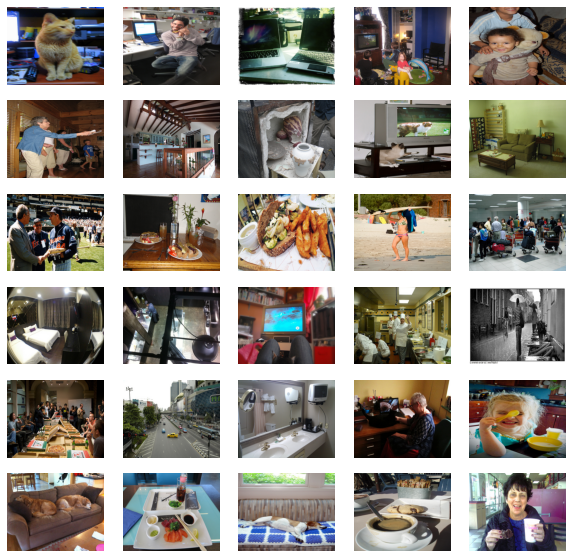

In [4]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(10, 10), facecolor='white', squeeze=True)
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path), aspect='auto')
    ax.axis("off")

In [5]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(),  
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")  
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. 
        ab = img_lab[[1, 2], ...] / 110. 
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): 
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                 pin_memory=pin_memory)
    return dataloader

In [7]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(len(train_dl), len(val_dl))

500 125


In [8]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [9]:
class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)]  
                                                   
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]  
                                                                                              
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): 
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]       
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [11]:
print(PatchDiscriminator(input_c=3))      

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [12]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='car', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'car':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [13]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [14]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c = 1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c = 3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='car').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [17]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab): 
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/10
Iteration 400/500
loss_D_fake: 0.48069
loss_D_real: 0.49682
loss_D: 0.48876
loss_G_GAN: 1.56655
loss_G_L1: 9.80573
loss_G: 11.37227


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 182 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 150 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1290 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 61 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 62 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/

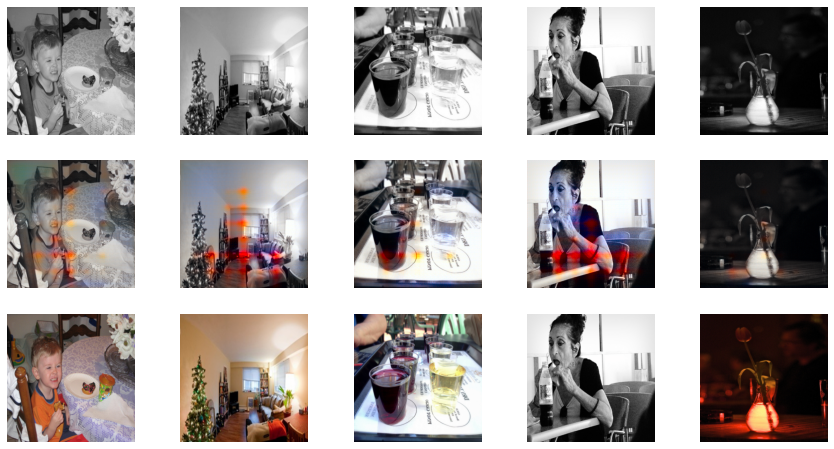

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2/10
Iteration 400/500
loss_D_fake: 0.51999
loss_D_real: 0.55298
loss_D: 0.53649
loss_G_GAN: 1.33540
loss_G_L1: 10.78426
loss_G: 12.11966


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 41 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 94 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 173 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 47 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/ut

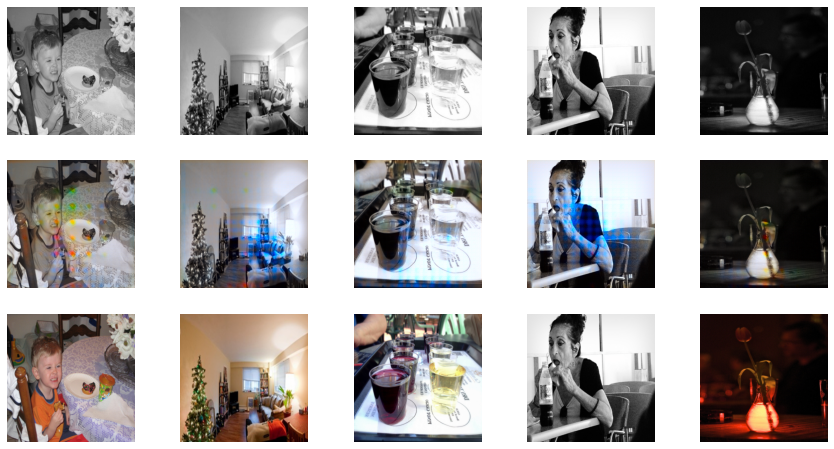

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3/10
Iteration 400/500
loss_D_fake: 0.52302
loss_D_real: 0.56582
loss_D: 0.54442
loss_G_GAN: 1.29389
loss_G_L1: 10.91192
loss_G: 12.20581


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 117 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 32 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 35 pixels
  return func(*args, **kwargs)


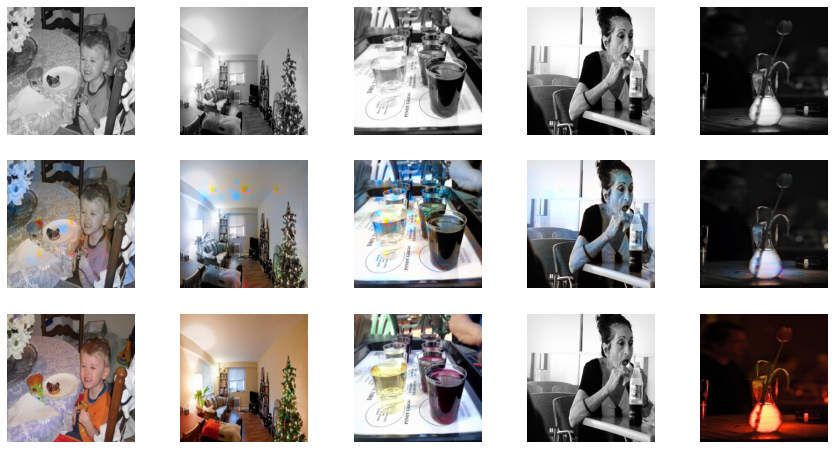

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 4/10
Iteration 400/500
loss_D_fake: 0.53262
loss_D_real: 0.58210
loss_D: 0.55736
loss_G_GAN: 1.23855
loss_G_L1: 10.88130
loss_G: 12.11986


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 122 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 44 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 227 pixels
  return func(*args, **kwargs)


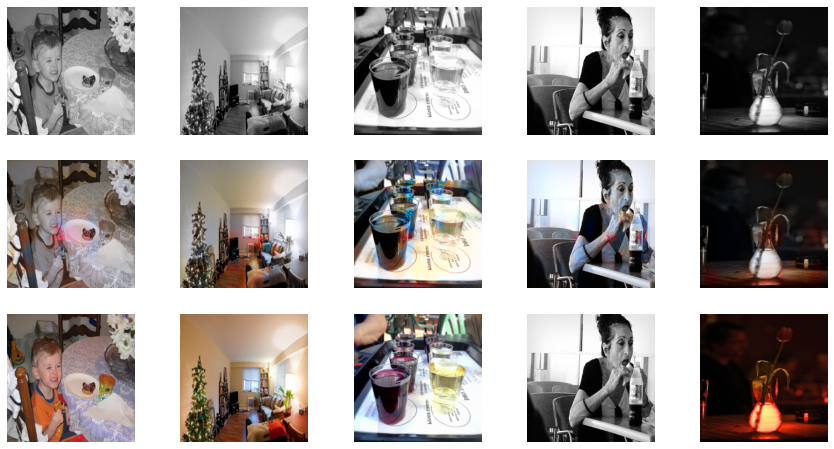

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 5/10
Iteration 400/500
loss_D_fake: 0.53792
loss_D_real: 0.58713
loss_D: 0.56252
loss_G_GAN: 1.22418
loss_G_L1: 10.85344
loss_G: 12.07762


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 121 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 139 pixels
  return func(*args, **kwargs)


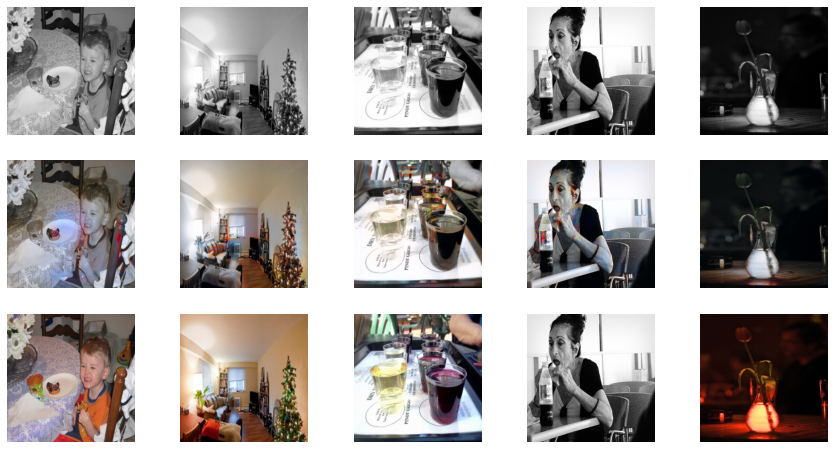

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 6/10
Iteration 400/500
loss_D_fake: 0.53743
loss_D_real: 0.58455
loss_D: 0.56099
loss_G_GAN: 1.22684
loss_G_L1: 10.82325
loss_G: 12.05009


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 156 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 17 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return func(*args, **kwargs)


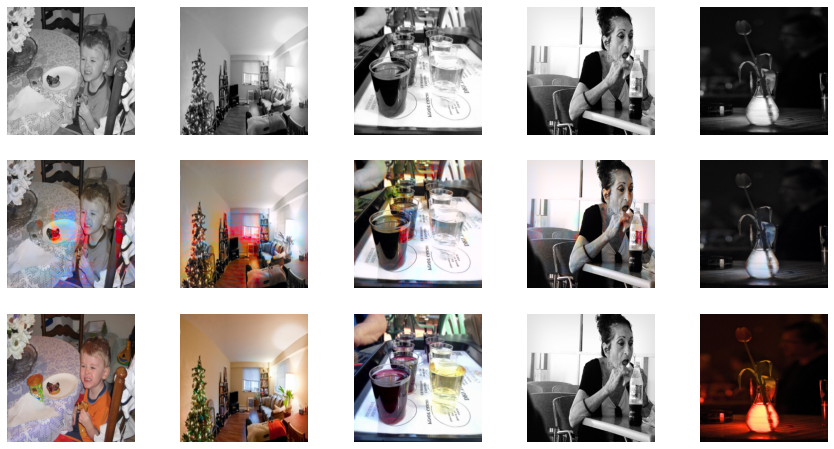

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 7/10
Iteration 400/500
loss_D_fake: 0.53627
loss_D_real: 0.58246
loss_D: 0.55936
loss_G_GAN: 1.23024
loss_G_L1: 10.75516
loss_G: 11.98539


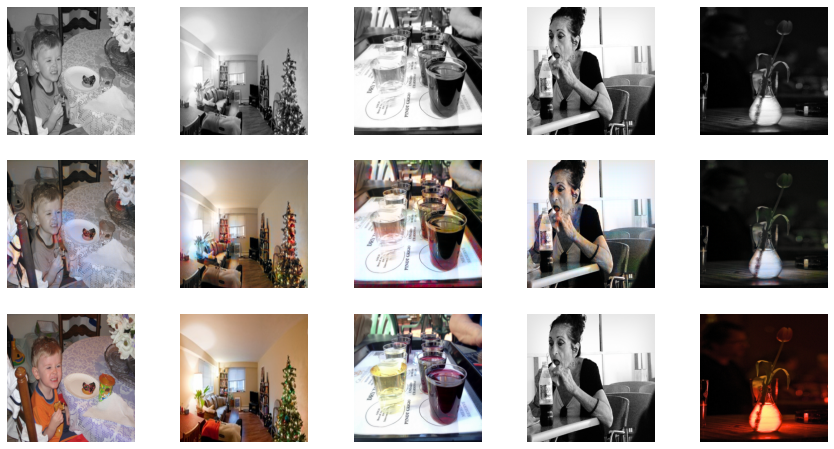

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 8/10
Iteration 400/500
loss_D_fake: 0.53570
loss_D_real: 0.58456
loss_D: 0.56013
loss_G_GAN: 1.22665
loss_G_L1: 10.67526
loss_G: 11.90191


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 38 pixels
  return func(*args, **kwargs)


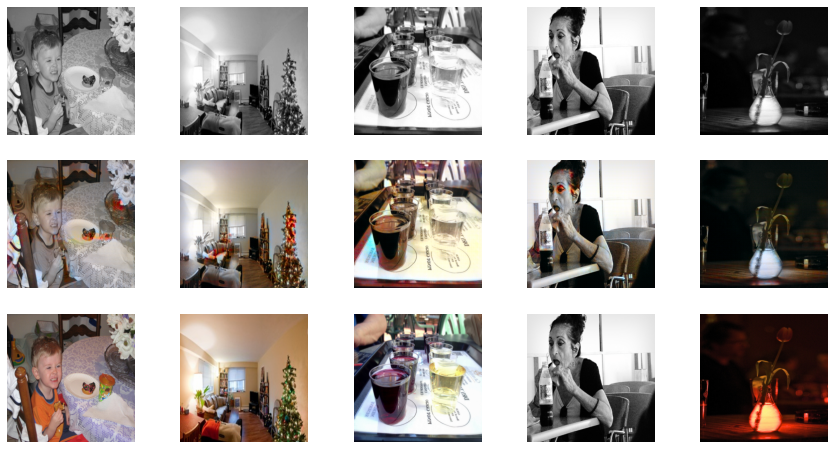

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 9/10
Iteration 400/500
loss_D_fake: 0.53709
loss_D_real: 0.58656
loss_D: 0.56183
loss_G_GAN: 1.22578
loss_G_L1: 10.57570
loss_G: 11.80148


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 24 pixels
  return func(*args, **kwargs)


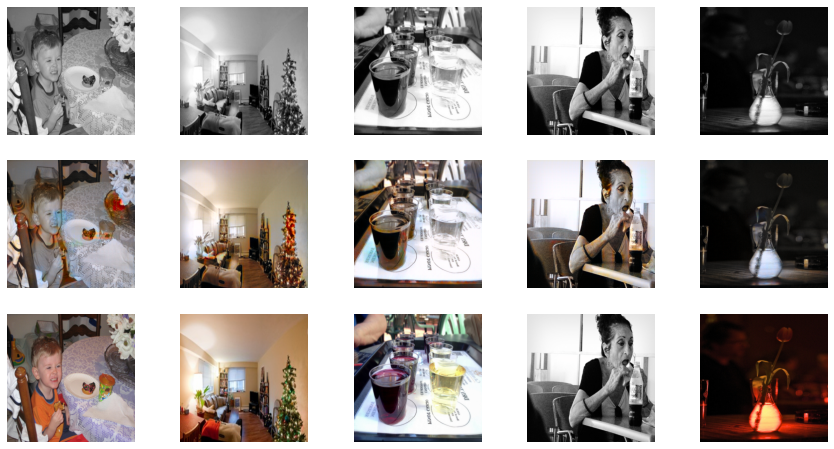

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 10/10
Iteration 400/500
loss_D_fake: 0.53499
loss_D_real: 0.58325
loss_D: 0.55912
loss_G_GAN: 1.21494
loss_G_L1: 10.48430
loss_G: 11.69924


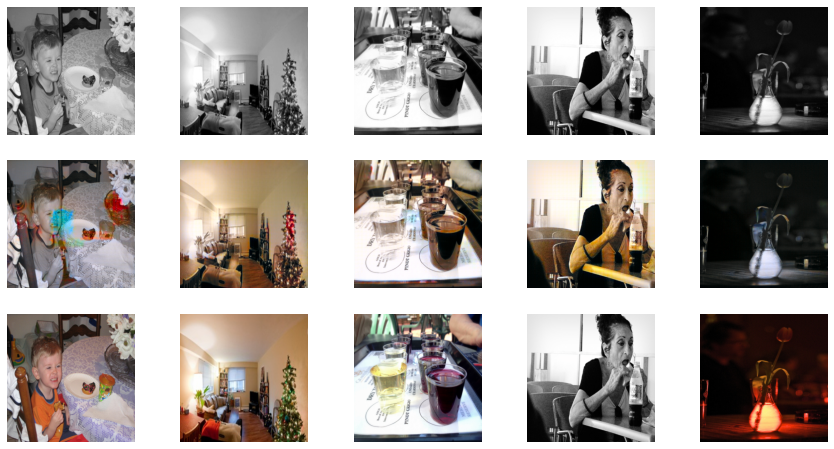

In [18]:
def train_model(model, train_dl, epochs, display_every=400):
    data = next(iter(val_dl))  
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() 
        i = 0                                  
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) 
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) 
                visualize(model, data, save=False) 

model = MainModel()
train_model(model, train_dl, 10)